<a href="https://colab.research.google.com/github/kamilarakhimova/hse-cvt/blob/main/Exercise2_Linear_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download dataset with Pytorch



## Load the data

In [ ]:
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import torch
from PIL import Image

RANDOM_STATE = 42
GENERATOR = torch.manual_seed(RANDOM_STATE)

# Define transformation for each image
transform  = transforms.Compose([
    transforms.Lambda(lambda x: np.array(x).flatten()) #Stretch image into row [32,32,3] -> [3072]
      ])

# Download a CIFAR10 dataset
dataset = datasets.CIFAR10("content",
                           train=True,
                           transform = transform,
                           download=True)


Files already downloaded and verified


## Split dataset & define dataloaders

torch.Size([256, 3072]) torch.Size([256])


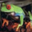

6

In [ ]:
train_ds, val_ds, _ = random_split(dataset, [20000, 1000, 29000], GENERATOR)

batch_size = 256

train_loader = DataLoader(train_ds, batch_size = batch_size)
val_loader = DataLoader(val_ds, batch_size = batch_size)

# Test Dataloader
for images, class_nums in train_loader:
  print(images.shape, class_nums.shape) # class_nums are tensor!
  pil_img = Image.fromarray(images[0].reshape(32, 32, 3).numpy())
  display(pil_img,
          class_nums[0].item()
          )
  break


# Implement LinearClassifier class for CIFAR10

In [ ]:
class LinearClassifier:
  def __init__(self, labels, ):
    self.labels = labels
    self.classes_num = len(labels)
    self.W = np.random.randn(3072, self.classes_num) * 0.0001
    self.batch_size = 200

  def train(self, x_batch, y_batch, learning_rate = 1e-8):
    """
      Arguments:
        x  (numpy.array): collection of objects (batch)
        y  (numpy.array): collection of integer
        representing a class number for objects from x

    """

    loss_val, grad = self.loss(x_batch, y_batch)

    # update weights
    self.W -= learning_rate * grad

    return loss_val / x_batch.shape[0]

  def loss(self, x, y):    # x and y are batches
    """
      Arguments:
        x  (numpy.array): collection of objects (batch)
        y  (numpy.array): collection of integer
        representing a class number for objects from x

    """

    loss = 0.0
    dW = np.zeros(self.W.shape)

    # calculate Multiclass SVM loss over a batch
    delta = 1.0
    scores = x.dot(self.W)
    y_scores = scores[np.arange(x.shape[0]), y]
    margins = np.maximum(0, scores - y_scores[:, np.newaxis] + delta)
    margins[np.arange(x.shape[0]), y] = 0
    loss = np.sum(margins)

    # calculate gradients (dL/dW) and store it in dW
    binary = margins
    binary[margins > 0] = 1
    row_sum = np.sum(binary, axis=1)
    binary[np.arange(x.shape[0]), y] = -row_sum.T
    dW = np.dot(x.T, binary)

    dW /= x.shape[0]

    return loss, dW

  def predict(self,x):
    scores = x.dot(self.W)
    return np.argmax(scores,axis = 1)

# Train model

## Function for accuracy checking

Don't change this code

In [ ]:
from sklearn.metrics import accuracy_score

def validate(model, dataloader):
  y_predicted = np.array([])
  y_gtrue = np.array([])
  for images, class_nums in dataloader:
    index = model.predict(images.numpy())
    y_predicted = np.append(y_predicted, index)
    y_gtrue = np.append(y_gtrue, class_nums.numpy())
  return accuracy_score(y_gtrue, y_predicted)

## Train loop
Let's train our model

In [ ]:
model = LinearClassifier(dataset.classes)
best_accuracy = 0
for epoch in range(25):
  for images, class_nums in train_loader:
    loss = model.train(images.numpy(), class_nums.numpy())
    accuracy = validate(model,val_loader)
  if best_accuracy < accuracy:
    best_accuracy = accuracy
  print(f"Epoch {epoch} Loss: {loss}, Accuracy: {accuracy}")

print(f"Best accuracy is {best_accuracy}")

Epoch 0 Loss: 6.335427094895989, Accuracy: 0.191
Epoch 1 Loss: 5.106434270682216, Accuracy: 0.219
Epoch 2 Loss: 4.483723152078512, Accuracy: 0.241
Epoch 3 Loss: 4.110670588891439, Accuracy: 0.263
Epoch 4 Loss: 3.852096054425542, Accuracy: 0.286
Epoch 5 Loss: 3.6589269236956863, Accuracy: 0.302
Epoch 6 Loss: 3.50975009955449, Accuracy: 0.308
Epoch 7 Loss: 3.3894617362326454, Accuracy: 0.309
Epoch 8 Loss: 3.2918774168508778, Accuracy: 0.319
Epoch 9 Loss: 3.208145115314566, Accuracy: 0.319
Epoch 10 Loss: 3.1367132367327994, Accuracy: 0.323
Epoch 11 Loss: 3.0638529505146614, Accuracy: 0.326
Epoch 12 Loss: 3.000599023514957, Accuracy: 0.335
Epoch 13 Loss: 2.9455941014561864, Accuracy: 0.336
Epoch 14 Loss: 2.8910021040821747, Accuracy: 0.34
Epoch 15 Loss: 2.8365123358754936, Accuracy: 0.342
Epoch 16 Loss: 2.7854898827819055, Accuracy: 0.346
Epoch 17 Loss: 2.740490761763814, Accuracy: 0.349
Epoch 18 Loss: 2.700938440084457, Accuracy: 0.35
Epoch 19 Loss: 2.6618598636965, Accuracy: 0.351
Epoch 

# Check model on test dataset

You must get accuracy above 0.35


In [ ]:
test_dataset = datasets.CIFAR10("content",
                           train=False,
                           transform = transform, # Transforms stay the same
                           download=True)

test_loader = DataLoader(test_dataset, batch_size = len(test_dataset))


accuracy = validate(model,test_loader)
print(f"Accuracy on test: {accuracy}, rounding to 2 decimal places we get accuracy: {round(accuracy, 2)}")


Files already downloaded and verified
Accuracy on test: 0.3489, rounding to 2 decimal places we get accuracy: 0.35


# Place for brief conclusion

Сразу бросается в глаза кардинальное улучшение результатов метрики `accuracy` в сравнении с её результатами в прошлой домашней работе, при использовании алгоритма `kNN`. Также гораздо меньше требуется вычислительных мощностей и памяти: `линейный классификатор` работает значительно быстрее, так как не требует прохождения много раз циклом по обучающей выборке, да и в целом, после обработки данных и получения значений весов, обучающая выборка более не нужна.


В ходе моих экспериментов выяснилось, что лучше всего линейный классификатор предсказывает классы изображений из датасета `CIFAR10` с функцией потерь SVM и регуляризатором, судя по данным метрики `accuracy`.



# Ideas for extra work

- Implement CrossEntropyLoss function✅
- Add regularization to SVM loss✅
- Normalize data✅




## Implement Cross Entropy loss function

In [ ]:
transform  = transforms.Compose([
    transforms.Lambda(lambda x: np.array(x).flatten())
      ])

dataset = datasets.CIFAR10("content",
                           train=True,
                           transform = transform,
                           download=True)

train_ds, val_ds, _ = random_split(dataset, [20000, 1000, 29000], GENERATOR)

batch_size = 256

train_loader = DataLoader(train_ds, batch_size = batch_size)
val_loader = DataLoader(val_ds, batch_size = batch_size)


Files already downloaded and verified


In [ ]:
class LinearClassifierCE:
  def __init__(self, labels, ):
    self.labels = labels
    self.classes_num = len(labels)
    self.W = np.random.randn(3072, self.classes_num) * 0.0001
    self.batch_size = 200

  def train(self, x_batch, y_batch, learning_rate = 1e-8):
    loss_val, grad = self.loss(x_batch, y_batch)

    self.W -= learning_rate * grad

    return loss_val / x_batch.shape[0]

  def loss(self, x, y):
    loss = 0.0
    dW = np.zeros(self.W.shape)

    # calculate Cross Enthropy loss over a batch
    scores = x.dot(self.W)
    scores -= np.max(scores, axis=1)[:, np.newaxis]
    p = np.exp(scores) / np.sum(np.exp(scores), axis=1)[:, np.newaxis]

    loss -= np.sum(np.log(p[np.arange(x.shape[0]), y]))

    # calculate gradients (dL/dW) and store it in dW
    probs = p
    probs[np.arange(x.shape[0]), y] -= 1

    dW = x.T.dot(probs)

    dW /= x.shape[0]

    return loss, dW

  def predict(self,x):
    scores = x.dot(self.W)
    return np.argmax(scores,axis = 1)

In [ ]:
model = LinearClassifierCE(dataset.classes)
best_accuracy = 0
for epoch in range(25):
  for images, class_nums in train_loader:
    loss = model.train(images.numpy(), class_nums.numpy())
    accuracy = validate(model,val_loader)
  if best_accuracy < accuracy:
    best_accuracy = accuracy
  print(f"Epoch {epoch} Loss: {loss}, Accuracy: {accuracy}")

print(f"Best accuracy is {best_accuracy}")

Epoch 0 Loss: 2.340380909387698, Accuracy: 0.132
Epoch 1 Loss: 2.2974845972756626, Accuracy: 0.16
Epoch 2 Loss: 2.262221916432066, Accuracy: 0.172
Epoch 3 Loss: 2.232302242821664, Accuracy: 0.182
Epoch 4 Loss: 2.2066698777163385, Accuracy: 0.197
Epoch 5 Loss: 2.1845077359389222, Accuracy: 0.21
Epoch 6 Loss: 2.1651774294943915, Accuracy: 0.218
Epoch 7 Loss: 2.1481779175029554, Accuracy: 0.236
Epoch 8 Loss: 2.1331131983726666, Accuracy: 0.245
Epoch 9 Loss: 2.119667707233236, Accuracy: 0.251
Epoch 10 Loss: 2.1075878024852583, Accuracy: 0.255
Epoch 11 Loss: 2.0966678688691838, Accuracy: 0.263
Epoch 12 Loss: 2.0867398544322233, Accuracy: 0.268
Epoch 13 Loss: 2.0776653443400392, Accuracy: 0.272
Epoch 14 Loss: 2.0693295092746347, Accuracy: 0.275
Epoch 15 Loss: 2.0616364451504507, Accuracy: 0.277
Epoch 16 Loss: 2.0545055525098177, Accuracy: 0.283
Epoch 17 Loss: 2.047868699147497, Accuracy: 0.29
Epoch 18 Loss: 2.0416679779220823, Accuracy: 0.293
Epoch 19 Loss: 2.0358539208723987, Accuracy: 0.29

In [ ]:
test_dataset = datasets.CIFAR10("content",
                           train=False,
                           transform = transform,
                           download=True)

test_loader = DataLoader(test_dataset, batch_size = len(test_dataset))


accuracy = validate(model,test_loader)
print(f"Accuracy on test: {accuracy}, rounding to 2 decimal places we get accuracy: {round(accuracy, 2)}")


Files already downloaded and verified
Accuracy on test: 0.3012, rounding to 2 decimal places we get accuracy: 0.3


## Add regularization to SVM loss (the squared L2 norm)

In [ ]:
class LinearClassifierWithReg:
  def __init__(self, labels, ):
    self.labels = labels
    self.classes_num = len(labels)
    self.W = np.random.randn(3072, self.classes_num) * 0.0001
    self.batch_size = 200

  def train(self, x_batch, y_batch, learning_rate = 1e-8, reg=1e-6):
    loss_val, grad = self.loss(x_batch, y_batch, reg)

    # update weights
    self.W -= learning_rate * grad

    return loss_val / x_batch.shape[0] + reg * np.sum(self.W * self.W)

  def loss(self, x, y, reg):    # x and y are batches
    loss = 0.0
    dW = np.zeros(self.W.shape)

    # calculate Multiclass SVM loss over a batch (with regularization)
    delta = 1.0
    scores = x.dot(self.W)
    y_scores = scores[np.arange(x.shape[0]), y]
    margins = np.maximum(0, scores - y_scores[:, np.newaxis] + delta)
    margins[np.arange(x.shape[0]), y] = 0
    loss = np.sum(margins)

    # calculate gradients (dL/dW) and store it in dW
    binary = margins
    binary[margins > 0] = 1
    row_sum = np.sum(binary, axis=1)
    binary[np.arange(x.shape[0]), y] = -row_sum.T
    dW = np.dot(x.T, binary)

    dW /= x.shape[0]
    dW += 2 * reg * self.W

    return loss, dW

  def predict(self,x):
    scores = x.dot(self.W)
    return np.argmax(scores,axis = 1)

In [ ]:
model = LinearClassifierWithReg(dataset.classes)
best_accuracy = 0
for epoch in range(25):
  for images, class_nums in train_loader:
    loss = model.train(images.numpy(), class_nums.numpy())
    accuracy = validate(model,val_loader)
  if best_accuracy < accuracy:
    best_accuracy = accuracy
  print(f"Epoch {epoch} Loss: {loss}, Accuracy: {accuracy}")

print(f"Best accuracy is {best_accuracy}")

Epoch 0 Loss: 5.626464941762967, Accuracy: 0.188
Epoch 1 Loss: 4.814485828749676, Accuracy: 0.236
Epoch 2 Loss: 4.361232655491445, Accuracy: 0.258
Epoch 3 Loss: 4.062898897422364, Accuracy: 0.262
Epoch 4 Loss: 3.8217498746757594, Accuracy: 0.278
Epoch 5 Loss: 3.6247071016803565, Accuracy: 0.291
Epoch 6 Loss: 3.478712820714233, Accuracy: 0.302
Epoch 7 Loss: 3.366909762382134, Accuracy: 0.317
Epoch 8 Loss: 3.280350422360774, Accuracy: 0.32
Epoch 9 Loss: 3.210025582961491, Accuracy: 0.322
Epoch 10 Loss: 3.1424415022389183, Accuracy: 0.324
Epoch 11 Loss: 3.0766555151213417, Accuracy: 0.327
Epoch 12 Loss: 3.0150425132092726, Accuracy: 0.327
Epoch 13 Loss: 2.960088708599476, Accuracy: 0.33
Epoch 14 Loss: 2.911855665266179, Accuracy: 0.331
Epoch 15 Loss: 2.868684451587943, Accuracy: 0.341
Epoch 16 Loss: 2.829985457366628, Accuracy: 0.34
Epoch 17 Loss: 2.789680553400929, Accuracy: 0.339
Epoch 18 Loss: 2.7529783017253027, Accuracy: 0.342
Epoch 19 Loss: 2.723179115683981, Accuracy: 0.343
Epoch 2

In [ ]:
test_dataset = datasets.CIFAR10("content",
                           train=False,
                           transform = transform, # Transforms stay the same
                           download=True)

test_loader = DataLoader(test_dataset, batch_size = len(test_dataset))


accuracy = validate(model,test_loader)
print(f"Accuracy on test: {accuracy}, rounding to 2 decimal places we get accuracy: {round(accuracy, 2)}")


Files already downloaded and verified
Accuracy on test: 0.3502, rounding to 2 decimal places we get accuracy: 0.35


## Normalize data

*Finding mean and std for train part of a dataset*

In [ ]:
train_loader = DataLoader(train_ds, batch_size = 200)

imgs = torch.stack([img_t for img_t, _ in train_loader], dim=1)
mean, std = imgs.view(3, -1).mean(dim=1), imgs.view(3, -1).std(dim=1)
print(f"mean: {mean}, std: {std}")

mean: tensor([0.4718, 0.4728, 0.4734]), std: tensor([0.2512, 0.2512, 0.2504])


In [ ]:
transformNorm  = transforms.Compose([
    transforms.ToTensor(),
      transforms.Normalize(mean, std),
        transforms.Lambda(lambda x: np.array(x).flatten()),
          ])

dataset = datasets.CIFAR10("content",
                           train=True,
                           transform = transformNorm,
                           download=True)

train_ds, val_ds, _ = random_split(dataset, [20000, 1000, 29000], GENERATOR)

batch_size = 256

train_loader = DataLoader(train_ds, batch_size = batch_size)
val_loader = DataLoader(val_ds, batch_size = batch_size)


Files already downloaded and verified


In [ ]:
model = LinearClassifier(dataset.classes)
best_accuracy = 0
for epoch in range(25):
  for images, class_nums in train_loader:
    loss = model.train(images.numpy(), class_nums.numpy())
    accuracy = validate(model,val_loader)
  if best_accuracy < accuracy:
    best_accuracy = accuracy
  print(f"Epoch {epoch} Loss: {loss}, Accuracy: {accuracy}")

print(f"Best accuracy is {best_accuracy}")

Epoch 0 Loss: 9.004444429807226, Accuracy: 0.108
Epoch 1 Loss: 9.001548600221051, Accuracy: 0.114
Epoch 2 Loss: 8.998652770634878, Accuracy: 0.119
Epoch 3 Loss: 8.995756941048704, Accuracy: 0.122
Epoch 4 Loss: 8.992861111462531, Accuracy: 0.127
Epoch 5 Loss: 8.989965281876357, Accuracy: 0.129
Epoch 6 Loss: 8.987069452290182, Accuracy: 0.132
Epoch 7 Loss: 8.98417362270401, Accuracy: 0.135
Epoch 8 Loss: 8.981277793117835, Accuracy: 0.14
Epoch 9 Loss: 8.97838196353166, Accuracy: 0.147
Epoch 10 Loss: 8.975486133945488, Accuracy: 0.148
Epoch 11 Loss: 8.972590304359313, Accuracy: 0.151
Epoch 12 Loss: 8.969694474773139, Accuracy: 0.15
Epoch 13 Loss: 8.966798645186966, Accuracy: 0.154
Epoch 14 Loss: 8.963902815600791, Accuracy: 0.159
Epoch 15 Loss: 8.961006986014617, Accuracy: 0.165
Epoch 16 Loss: 8.958111156428444, Accuracy: 0.167
Epoch 17 Loss: 8.95521532684227, Accuracy: 0.168
Epoch 18 Loss: 8.952319497256095, Accuracy: 0.176
Epoch 19 Loss: 8.949423667669922, Accuracy: 0.177
Epoch 20 Loss: 

In [ ]:
test_dataset = datasets.CIFAR10("content",
                           train=False,
                           transform = transformNorm,
                           download=True)

test_loader = DataLoader(test_dataset, batch_size = len(test_dataset))


accuracy = validate(model,test_loader)
print(f"Accuracy on test: {accuracy}, rounding to 2 decimal places we get accuracy: {round(accuracy, 2)}")


Files already downloaded and verified
Accuracy on test: 0.174, rounding to 2 decimal places we get accuracy: 0.17
